# Lab 9 - PCC177/BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## NLP

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Implementar técncias de PLN para resolver um problema de classificação de texto tóxico em portugues.

Data da entrega : Fim do período

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab.pdf"
- Envie o PDF via google [FORM](https://forms.gle/NeH2WCaqVG4n8iz88)

Este notebook é baseado em tensorflow e Keras.


# Importando bibliotecas e preparando o ambiente

Importando as bibliotecas

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

Montando o seu drive no colab.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Vamos carregar a base de dados "*Brazilian Portuguese Hatespeech dataset*". Para detalhes sobre o dataset e o problema em si, veja o [link do Kaggle](https://www.kaggle.com/datasets/hrmello/brazilian-portuguese-hatespeech-dataset/).

In [6]:
# Ler o arquivo CSV hate_speech_binary_classification_train.csv dentro da pasta de dataset do drive compartilhado.
# Substitua o 'caminho_do_arquivo_treino.csv' pelo caminho real do seu arquivo CSV
dados = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hate_speech_binary_classification_train.csv')

# Ler o arquivo CSV hate_speech_binary_classification_test.csv dentro da pasta de dataset do drive compartilhado.
# Substitua o 'caminho_do_arquivo_teste.csv' pelo caminho real do seu arquivo CSV
dados_teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hate_speech_binary_classification_test.csv')

Mostrar as primeiras linhas do DataFrame

In [7]:
print(dados.head())

                                                text  \
0  -Odeio feministas só falam merda\n-Vamos fazer...   
1  CHEGOU DANDO CANTADA NO CARNAVAL:\n#CarnavalSe...   
2  Diferença entre 'manifestante' e 'terrorista'....   
3  É legal pra um presidente 'grampear' uma corri...   
4  não há como negar a biologia....por mais que a...   

                                             protext  class  
0  -Odeio feministas só falam merda -Vamos fazer ...      1  
1  CHEGOU DANDO CANTADA NO CARNAVAL: #CarnavalSem...      0  
2  Diferença entre 'manifestante' e 'terrorista'....      1  
3  É legal pra um presidente 'grampear' uma corri...      0  
4  não há como negar a biologia....por mais que a...      0  


## Pré-processando os dados

Selecionando colunas específicas

In [8]:
dados_brutos = dados.iloc[:, 0]
X = dados.iloc[:, 1] # Coluna dos dados pré-processados
y = dados.iloc[:, 2] # Coluna dos rótulos

X_test = dados_teste.iloc[:, 1]  # Coluna dos dados pré-processados
y_test = dados_teste.iloc[:, 2]  # Coluna dos rótulos

Mostrar as primeiras linhas de cada coluna

In [9]:
print("Dados brutos:")
print(dados_brutos.head())
print("\nRótulos:")
print(y.head())
print("\nDados preprocessados:")
print(X.head())

Dados brutos:
0    -Odeio feministas só falam merda\n-Vamos fazer...
1    CHEGOU DANDO CANTADA NO CARNAVAL:\n#CarnavalSe...
2    Diferença entre 'manifestante' e 'terrorista'....
3    É legal pra um presidente 'grampear' uma corri...
4    não há como negar a biologia....por mais que a...
Name: text, dtype: object

Rótulos:
0    1
1    0
2    1
3    0
4    0
Name: class, dtype: int64

Dados preprocessados:
0    -Odeio feministas só falam merda -Vamos fazer ...
1    CHEGOU DANDO CANTADA NO CARNAVAL: #CarnavalSem...
2    Diferença entre 'manifestante' e 'terrorista'....
3    É legal pra um presidente 'grampear' uma corri...
4    não há como negar a biologia....por mais que a...
Name: protext, dtype: object


# Uma implementação ingênua para o problema

Abaixo uma implementação ingênua para o problema. Ela é ingênua por que desconsidera a ordem das palavras no texto.
Tente endendê-la e execute o treinamento.

### Pré-processamento

Primeira coisa é fixar as sementes para garantir a reproducibilidade dos resultados

In [10]:
np.random.seed(94)
tf.random.set_seed(94)

Codificação dos rótulos para 0 e 1

In [11]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_test = encoder.transform(y_test)

Tokenização e sequenciamento dos textos

In [12]:
max_length = 280  # Define o tamanho máximo das sequências
vocab_size = 100000  # Define o tamanho do vocabulário

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
# Tokenização e sequenciamento dos textos de treino
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Tokenização e sequenciamento dos textos de teste
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

Divisão dos dados em conjuntos de treino e validação

In [13]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

### Definição e treinamento do modelo

Definição do modelo

In [14]:
embedding_dim = 16

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 16)           1600000   
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 32)                143392    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1743425 (6.65 MB)
Trainable params: 1743425 (6.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo

In [17]:
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
72/72 - 11s - loss: 0.6939 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5035 - 11s/epoch - 158ms/step
Epoch 2/5
72/72 - 3s - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5035 - 3s/epoch - 46ms/step
Epoch 3/5
72/72 - 3s - loss: 0.6923 - accuracy: 0.5551 - val_loss: 0.6927 - val_accuracy: 0.5035 - 3s/epoch - 37ms/step
Epoch 4/5
72/72 - 2s - loss: 0.6564 - accuracy: 0.6700 - val_loss: 0.6562 - val_accuracy: 0.6259 - 2s/epoch - 25ms/step
Epoch 5/5
72/72 - 2s - loss: 0.3657 - accuracy: 0.9073 - val_loss: 0.6474 - val_accuracy: 0.6259 - 2s/epoch - 22ms/step


Plotando as curvas de loss

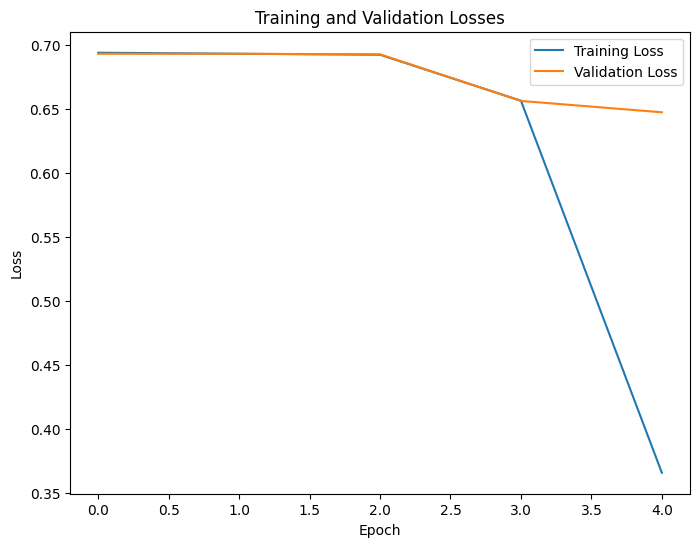

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [19]:
loss, accuracy = model.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

23/23 - 0s - loss: 0.6491 - accuracy: 0.6327 - 58ms/epoch - 3ms/step
Perda nos dados de teste: 0.6491
Acurácia nos dados de teste: 0.6327


Gerando o relatório de classificação

In [20]:
# y_pred = model.predict(y_test).reshape(1,-1)
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

23/23 [==============================] - 0s 2ms/step


Plotando os resultados

In [21]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.6208651399491094
	Recall: 0.6815642458100558
	F1-score: 0.6498002663115846
Class: 1
	Precision: 0.6470588235294118
	Recall: 0.5837988826815642
	F1-score: 0.6138032305433186
Class: macro avg
	Precision: 0.6339619817392605
	Recall: 0.63268156424581
	F1-score: 0.6318017484274516
Class: weighted avg
	Precision: 0.6339619817392607
	Recall: 0.63268156424581
	F1-score: 0.6318017484274516
Macro Avg: {'precision': 0.6339619817392605, 'recall': 0.63268156424581, 'f1-score': 0.6318017484274516, 'support': 716}
Weighted Avg: {'precision': 0.6339619817392607, 'recall': 0.63268156424581, 'f1-score': 0.6318017484274516, 'support': 716}


Plotando a matriz de confusão

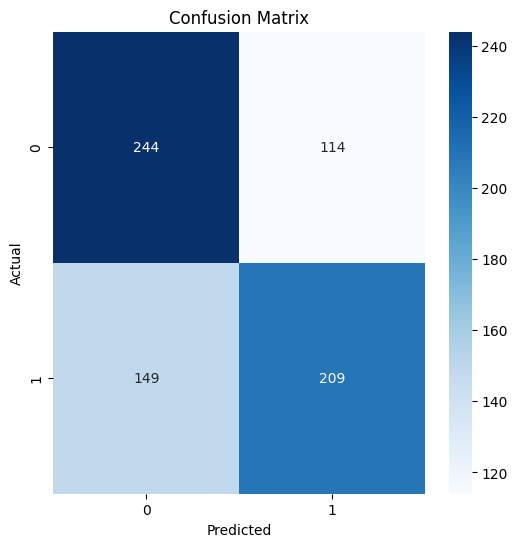

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Previsões do modelo

In [23]:
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")

23/23 [==============================] - 0s 2ms/step


### *ToDo*: O que você pode analisar dos resultados acima?

```
  Pode-se analisar que o modelo possui uma capacidade de detecção de verdadeiros positivos boa, etretanto classifica muitos negativos como positivos tambem, com baixissimo nivel de detecção de verdadeiros negativos.
```

# Faça o mesmo processamento utilizando GRU

Pelo menos duas camadas de GRU

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

embedding_dim = 16

model_GRU = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(64, return_sequences=True),  # Primeira camada GRU com 64 unidades e retorno de sequências
    GRU(32),  # Segunda camada GRU com 32 unidades
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 gru (GRU)                   (None, 280, 64)           15744     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1626241 (6.20 MB)
Trainable params: 1626

In [25]:
epochs = 5
history_GRU = model_GRU.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
72/72 - 12s - loss: 0.6937 - accuracy: 0.4904 - val_loss: 0.6932 - val_accuracy: 0.4965 - 12s/epoch - 168ms/step
Epoch 2/5
72/72 - 4s - loss: 0.6935 - accuracy: 0.4834 - val_loss: 0.6932 - val_accuracy: 0.4965 - 4s/epoch - 55ms/step
Epoch 3/5
72/72 - 3s - loss: 0.6935 - accuracy: 0.4930 - val_loss: 0.6933 - val_accuracy: 0.5035 - 3s/epoch - 38ms/step
Epoch 4/5
72/72 - 2s - loss: 0.6936 - accuracy: 0.4878 - val_loss: 0.6943 - val_accuracy: 0.4965 - 2s/epoch - 33ms/step
Epoch 5/5
72/72 - 2s - loss: 0.6935 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.5035 - 2s/epoch - 32ms/step


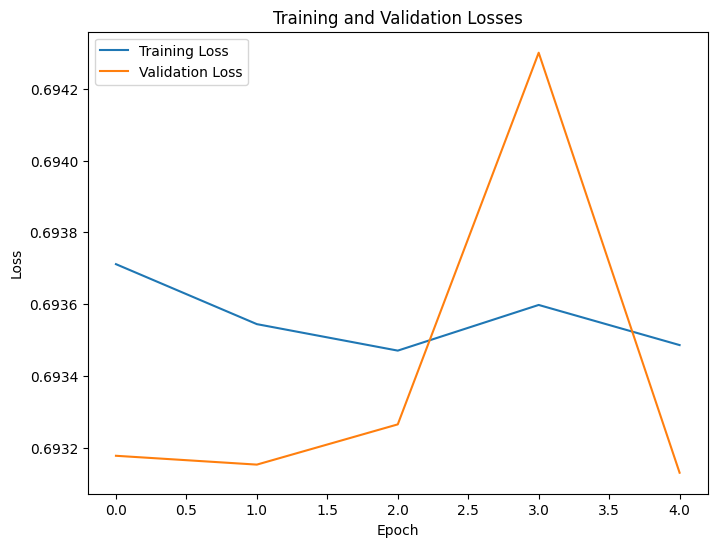

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Faça o mesmo processamento utilizando LSTM

Pelo menos duas camadas de LSTM

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_dim = 16

model_LSTM = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),  # Primeira camada GRU com 64 unidades e retorno de sequências
    LSTM(32),  # Segunda camada GRU com 32 unidades
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 lstm (LSTM)                 (None, 280, 64)           20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1634241 (6.23 MB)
Trainable params: 1634

In [28]:
epochs = 5
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
72/72 - 12s - loss: 0.6937 - accuracy: 0.4974 - val_loss: 0.6931 - val_accuracy: 0.5035 - 12s/epoch - 170ms/step
Epoch 2/5
72/72 - 3s - loss: 0.6934 - accuracy: 0.4843 - val_loss: 0.6932 - val_accuracy: 0.4965 - 3s/epoch - 44ms/step
Epoch 3/5
72/72 - 3s - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4965 - 3s/epoch - 39ms/step
Epoch 4/5
72/72 - 2s - loss: 0.6934 - accuracy: 0.4913 - val_loss: 0.6931 - val_accuracy: 0.5035 - 2s/epoch - 27ms/step
Epoch 5/5
72/72 - 2s - loss: 0.6934 - accuracy: 0.5052 - val_loss: 0.6932 - val_accuracy: 0.5035 - 2s/epoch - 34ms/step


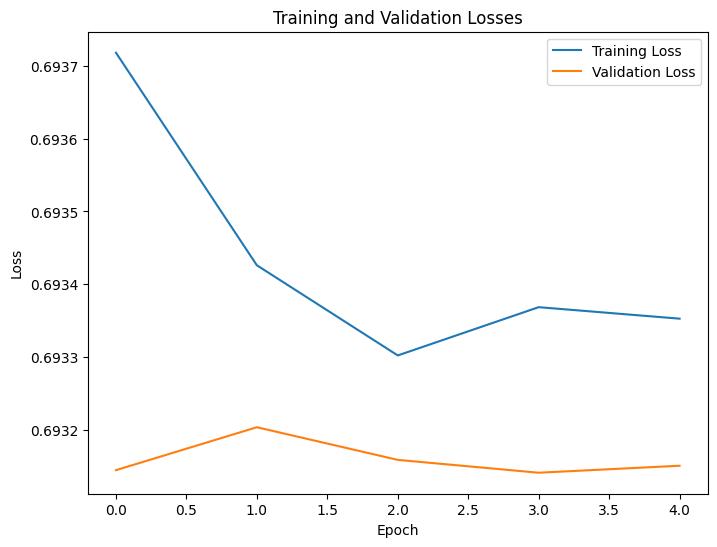

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Faça o mesmo processamento utilizando GRU Bi-direcionais

Pelo menos duas camadas de GRU bi-direcionais

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense

dimensao_incorporacao = 16

modelo_gru_bi = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True)),  # Primeira camada GRU bidirecional com 64 unidades e retorno de sequências
    Bidirectional(GRU(32)),  # Segunda camada GRU bidirecional com 32 unidades
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

modelo_gru_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

modelo_gru_bi.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 bidirectional (Bidirection  (None, 280, 128)          31488     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [31]:
epochs = 5
history_gru_bi= modelo_gru_bi.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
72/72 - 16s - loss: 0.6917 - accuracy: 0.5170 - val_loss: 0.6784 - val_accuracy: 0.5612 - 16s/epoch - 219ms/step
Epoch 2/5
72/72 - 4s - loss: 0.5340 - accuracy: 0.7404 - val_loss: 0.6452 - val_accuracy: 0.6486 - 4s/epoch - 60ms/step
Epoch 3/5
72/72 - 5s - loss: 0.2354 - accuracy: 0.9117 - val_loss: 0.8250 - val_accuracy: 0.6538 - 5s/epoch - 68ms/step
Epoch 4/5
72/72 - 3s - loss: 0.1048 - accuracy: 0.9642 - val_loss: 1.1686 - val_accuracy: 0.6136 - 3s/epoch - 42ms/step
Epoch 5/5
72/72 - 3s - loss: 0.0428 - accuracy: 0.9869 - val_loss: 1.4386 - val_accuracy: 0.6329 - 3s/epoch - 42ms/step


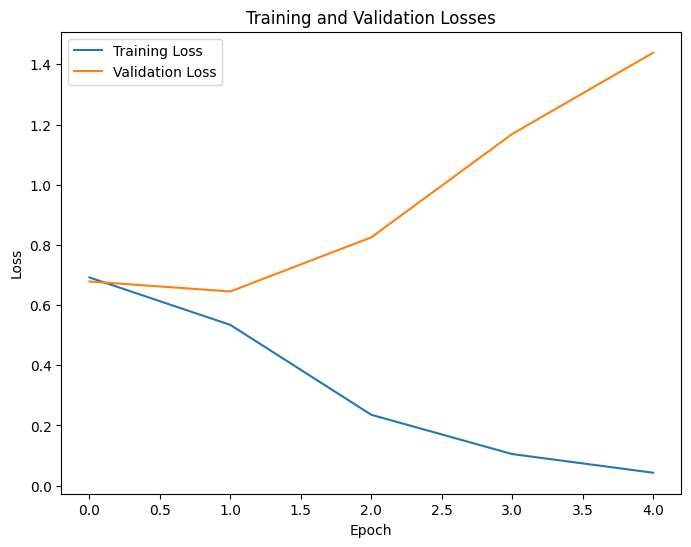

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(history_gru_bi.history['loss'], label='Training Loss')
plt.plot(history_gru_bi.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Faça o mesmo processamento utilizando LSTM Bi-direcionais

Pelo menos duas camadas de LSTM Bi-direcionais

Epoch 1/5
72/72 - 116s - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6926 - val_accuracy: 0.5682 - 116s/epoch - 2s/step
Epoch 2/5
72/72 - 108s - loss: nan - accuracy: 0.5686 - val_loss: nan - val_accuracy: 0.5035 - 108s/epoch - 1s/step
Epoch 3/5
72/72 - 104s - loss: nan - accuracy: 0.4991 - val_loss: nan - val_accuracy: 0.5035 - 104s/epoch - 1s/step
Epoch 4/5
72/72 - 104s - loss: nan - accuracy: 0.4991 - val_loss: nan - val_accuracy: 0.5035 - 104s/epoch - 1s/step
Epoch 5/5
72/72 - 106s - loss: nan - accuracy: 0.4991 - val_loss: nan - val_accuracy: 0.5035 - 106s/epoch - 1s/step
23/23 - 3s - loss: nan - accuracy: 0.5000 - 3s/epoch - 151ms/step
Perda nos dados de teste: nan
Acurácia nos dados de teste: 0.5000
23/23 [==============================] - 4s 160ms/step


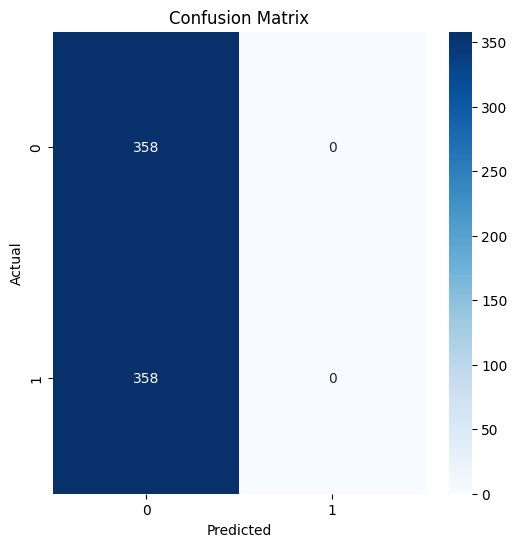

In [34]:
# ToDo
from tensorflow.keras.layers import  Bidirectional
# ToDo
embedding_dim = 16
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(32, activation='relu')),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)
loss, accuracy = model.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Faça o mesmo processamento utilizando redes recorrentes bi-direcionais e profundas

Pelo menos quatro camadas de GRU/LSTM bi-direcionais (ou não)

Epoch 1/5
72/72 - 254s - loss: 0.6934 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5035 - 254s/epoch - 4s/step
Epoch 2/5
72/72 - 236s - loss: 0.6792 - accuracy: 0.6311 - val_loss: 0.6612 - val_accuracy: 0.6294 - 236s/epoch - 3s/step
Epoch 3/5
72/72 - 248s - loss: nan - accuracy: 0.5752 - val_loss: nan - val_accuracy: 0.5035 - 248s/epoch - 3s/step
Epoch 4/5
72/72 - 236s - loss: nan - accuracy: 0.4991 - val_loss: nan - val_accuracy: 0.5035 - 236s/epoch - 3s/step
Epoch 5/5
72/72 - 233s - loss: nan - accuracy: 0.4991 - val_loss: nan - val_accuracy: 0.5035 - 233s/epoch - 3s/step
23/23 - 8s - loss: nan - accuracy: 0.5000 - 8s/epoch - 352ms/step
Perda nos dados de teste: nan
Acurácia nos dados de teste: 0.5000
23/23 [==============================] - 9s 345ms/step


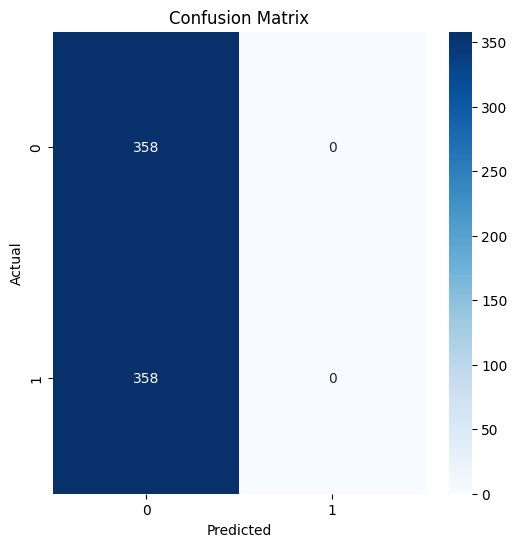

In [35]:
# # ToDo
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(32, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(32, activation='relu', return_sequences=True)),
    Bidirectional(GRU(32, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(32, activation='relu')),
    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)
loss, accuracy = model.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# *ToDo*: O que você pode analisar dos modelos treinados?

:```
Modelos que possum GRU Bi direcionais apresentam resultados mais equlibrados do que os puros e os LSTM. Não possuem uma qualidade de acertos apenas nos verdadeiros positivos```